In [1]:
import operator
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import gridspec
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.table import QTable
from astropy.coordinates import angular_separation
from magicctapipe.utils import (
    get_dl2_mean,
    check_tel_combination,
)
from pyirf.cuts import (
    evaluate_binned_cut,
    calculate_percentile_cut,
)
from pyirf.irf import effective_area_per_energy
from pyirf.simulations import SimulatedEventsInfo
from ctaplot.ana import (
    relative_bias,
    energy_resolution,
    angular_resolution,
)

In [2]:
# Display all columns of a pandas data frame:
pd.set_option('display.max_columns', None)

# Configure the pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': 'dotted',
})

In [3]:
def calculate_relative_difference(res_magic, res_mlst):
    """
    Calculates the relative differences of input two resolutions and their errors.
    """
    
    rel_diff = (res_mlst[:, 0] - res_magic[:, 0]) / res_magic[:, 0]
    
    lower_err_magic = res_magic[:, 0] - res_magic[:, 1]
    upper_err_magic = res_magic[:, 2] - res_magic[:, 0]
    
    lower_err_mlst = res_mlst[:, 0] - res_mlst[:, 1]
    upper_err_mlst = res_mlst[:, 2] - res_mlst[:, 0]
    
    rel_diff_err = [
        np.sqrt(lower_err_mlst**2 + (res_mlst[:, 0]*lower_err_magic/res_magic[:, 0])**2) / res_magic[:, 0],
        np.sqrt(upper_err_mlst**2 + (res_mlst[:, 0]*upper_err_magic/res_magic[:, 0])**2) / res_magic[:, 0],
    ]
    
    return rel_diff, rel_diff_err

# Load MAGIC DL2 data

### Load an input file and apply quality cuts:

In [4]:
# ================
# === Settings ===
# ================

input_file = '/home/yoshiki.ohtani/lstmagic/mc/zd40deg_az90deg/magic_only_analysis/4.dl1_stereo_to_dl2/data/' \
             'gamma_off0.4deg/dl2_with_slope/merged/dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5'

quality_cuts = None # 'intensity_width_2 < 0.2'

# ============
# === Main ===
# ============

print('Loading the following file:')
print(Path(input_file).name)

data_magic = pd.read_hdf(input_file, key='events/parameters')
data_magic.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_magic.sort_index(inplace=True)

if quality_cuts is not None:
    
    print('Applying the quality cuts:')
    print(quality_cuts)

    data_magic.query(quality_cuts, inplace=True)
    data_magic['multiplicity'] = data_magic.groupby(['obs_id', 'event_id']).size()
    data_magic.query('multiplicity > 1', inplace=True)

combo_types = check_tel_combination(data_magic)
data_magic.update(combo_types)

print('\nDone.')

Loading the following file:
dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5



In total 602719 stereo events are found:
m1_m2 (type 0): 602719 events (100.0%)
lst1_m1 (type 1): 0 events (0.0%)
lst1_m2 (type 2): 0 events (0.0%)
lst1_m1_m2 (type 3): 0 events (0.0%)



Done.


In [5]:
data_magic.head()

pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id tel_id                                                     
401    13603    2           0.865683     1.570796     0.623625      50.0   
                3           0.865683     1.570796     0.623625      50.0   
       13605    2           0.865683     1.570796     0.623625      50.0   
                3           0.865683     1.570796     0.623625      50.0   
       13606    2           0.865683     1.570796     0.623625      50.0   

                          true_az  true_disp  true_core_x  true_core_y  \
obs_id event_id tel_id                                                   
401    13603    2       89.999996   0.272132   -13.296012   -13.278467   
                3       89.999996   0.111020   -13.296012   -13.278467   
       13605    2       89.999996   0.938422  -153.317642  -135.251175   
                3       89.999996   0.699730  -153.317642  -135.251175   
       13606    2       89.999996   0.434992   -43.840717     8.326108   

                        true_impact  n_pixels  n_islands  magic_stereo  \
obs_id event_id tel_id                                                   
401    13603    2         53.781362        32          1          True   
                3         31.802946        25          1          True   
       13605    2        209.426836        22          1          True   
                3        171.002237        39          1          True   
       13606    2         87.658801        32          1          True   

                         intensity  skewness  kurtosis         x         y  \
obs_id event_id tel_id                                                       
401    13603    2       434.728504 -0.343120  2.870320  0.143219  0.076926   
                3       401.002982 -0.132237  2.914418  0.094569 -0.022443   
       13605    2       229.083606 -0.366884  2.329474  0.020834  0.260677   
                3       595.507656 -0.667485  2.880328 -0.017806  0.156443   
       13606    2       430.095625  0.253850  2.562339  0.167413  0.119515   

                               r        phi    length  length_uncertainty  \
obs_id event_id tel_id                                                      
401    13603    2       0.162571  28.241054  0.037293            0.001223   
                3       0.097195 -13.350277  0.037674            0.001302   
       13605    2       0.261508  85.430587  0.050627            0.001928   
                3       0.157453  96.493489  0.062713            0.001762   
       13606    2       0.205696  35.522732  0.045312            0.001365   

                           width  width_uncertainty        psi  intercept  \
obs_id event_id tel_id                                                      
401    13603    2       0.032942           0.001101 -25.947909   9.273974   
                3       0.022410           0.000801 -13.758246   9.918584   
       13605    2       0.021235           0.001008 -65.490775  10.019512   
                3       0.024093           0.000811 -48.093963   9.798699   
       13606    2       0.031363           0.001089  66.101732   9.700917   

                        deviation      slope  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                         
401    13603    2        0.795555   6.680368             0.0             0.0   
                3        0.632698   5.841154             0.0             0.0   
       13605    2        0.493670 -10.247479             0.0             0.0   
                3        0.583377  -2.631062             0.0             0.0   
       13606    2        0.516398 -11.279400             0.0             0.0   

                        intensity_width_1  intensity_width_2  multiplicity  \
obs_id event_id tel_id                                                       
401    13603    2                     0.0                0.0             2   
                3              

### Compute the mean of the DL2 parameters:

In [6]:
dl2_magic = get_dl2_mean(data_magic)

theta = angular_separation(
    lon1=u.Quantity(dl2_magic['true_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_magic['true_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_magic['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_magic['reco_alt'].to_numpy(), u.deg),
)

dl2_magic['theta2'] = theta.to(u.deg).value ** 2

In [7]:
dl2_magic.head()

combo_type  multiplicity  gammaness  reco_energy   reco_alt  \
obs_id event_id                                                                
401    13603            0.0           2.0   0.848845     0.497145  50.340919   
       13605            0.0           2.0   0.982917     0.497364  50.074391   
       13606            0.0           2.0   0.914417     0.496034  50.104182   
       13609            0.0           2.0   0.979375     0.519562  50.005690   
       15600            0.0           2.0   0.911250     0.231427  49.773704   

                   reco_az  pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id                                                                
401    13603     89.867777      0.865683     1.570796     0.623625      50.0   
       13605     89.933338      0.865683     1.570796     0.623625      50.0   
       13606     89.963853      0.865683     1.570796     0.623625      50.0   
       13609     89.993197      0.865683     1.570796     0.623625      50.0   
       15600     90.002103      0.865683     1.570796     0.216644      50.0   

                   true_az    theta2  
obs_id event_id                       
401    13603     89.999996  0.123397  
       13605     89.999996  0.007367  
       13606     89.999996  0.011392  
       13609     89.999996  0.000051  
       15600     89.999996  0.051212

# Load LST-1 + MAGIC DL2 data

### Load an input file and apply quality cuts:

In [8]:
# ================
# === Settings ===
# ================

input_file = '/home/yoshiki.ohtani/lstmagic/mc/zd40deg_az90deg/4.dl1_stereo_to_dl2/data/' \
             'gamma_off0.4deg/dl2_with_slope/merged/dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5'

quality_cuts = None # 'intensity_width_2 < 0.2'

# ============
# === Main ===
# ============

print('Loading the following file:')
print(Path(input_file).name)

data_mlst = pd.read_hdf(input_file, key='events/parameters')
data_mlst.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_mlst.sort_index(inplace=True)

if quality_cuts is not None:

    print('Applying the quality cuts:')
    print(quality_cuts)

    data_mlst.query(quality_cuts, inplace=True)
    data_mlst['multiplicity'] = data_mlst.groupby(['obs_id', 'event_id']).size()
    data_mlst.query('multiplicity > 1', inplace=True)

combo_types = check_tel_combination(data_mlst)
data_mlst.update(combo_types)

print('Extracting only 3-tels events...')
data_mlst.query('combo_type == 3', inplace=True)

print('\nDone.')

Loading the following file:
dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5



In total 1066666 stereo events are found:
m1_m2 (type 0): 5013 events (0.5%)
lst1_m1 (type 1): 163802 events (15.4%)
lst1_m2 (type 2): 300145 events (28.1%)
lst1_m1_m2 (type 3): 597706 events (56.0%)


Extracting only 3-tels events...

Done.


In [9]:
data_mlst.head()

pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id tel_id                                                     
401    13603    1           0.865683     1.570796     0.623625      50.0   
                2           0.865683     1.570796     0.623625      50.0   
                3           0.865683     1.570796     0.623625      50.0   
       13605    1           0.865683     1.570796     0.623625      50.0   
                2           0.865683     1.570796     0.623625      50.0   

                          true_az  true_disp  true_core_x  true_core_y  \
obs_id event_id tel_id                                                   
401    13603    1       89.999996   0.457740   -13.296012   -13.278467   
                2       89.999996   0.272132   -13.296012   -13.278467   
                3       89.999996   0.111020   -13.296012   -13.278467   
       13605    1       89.999996   1.047734  -153.317642  -135.251175   
                2       89.999996   0.938422  -153.317642  -135.251175   

                        true_impact  n_pixels  n_islands  magic_stereo  \
obs_id event_id tel_id                                                   
401    13603    1         97.036521        39          1          True   
                2         53.781362        32          1          True   
                3         31.802946        25          1          True   
       13605    1        239.411421        36          1          True   
                2        209.426836        22          1          True   

                          intensity  skewness  kurtosis         x         y  \
obs_id event_id tel_id                                                        
401    13603    1       1274.284458 -0.423830  2.561445 -0.026957  0.023705   
                2        434.728504 -0.343120  2.870320  0.143219  0.076926   
                3        401.002982 -0.132237  2.914418  0.094569 -0.022443   
       13605    1        645.362629 -0.452583  2.619371 -0.205826  0.317994   
                2        229.083606 -0.366884  2.329474  0.020834  0.260677   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
401    13603    1       0.035897  138.673213  0.097366            0.001704   
                2       0.162571   28.241054  0.037293            0.001223   
                3       0.097195  -13.350277  0.037674            0.001302   
       13605    1       0.378794  122.913450  0.137288            0.003439   
                2       0.261508   85.430587  0.050627            0.001928   

                           width  width_uncertainty        psi  intercept  \
obs_id event_id tel_id                                                      
401    13603    1       0.043809           0.001297 -10.241325  13.728943   
                2       0.032942           0.001101 -25.947909   9.273974   
                3       0.022410           0.000801 -13.758246   9.918584   
       13605    1       0.032342           0.001029 -36.311899  14.051225   
                2       0.021235           0.001008 -65.490775  10.019512   

                        deviation      slope  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                         
401    13603    1        1.419852   2.185489             0.0             0.0   
                2        0.795555   6.680368             0.0             0.0   
                3        0.632698   5.841154             0.0             0.0   
       13605    1        0.743845  -8.365208             0.0             0.0   
                2        0.493670 -10.247479             0.0             0.0   

                        intensity_width_1  intensity_width_2  multiplicity  \
obs_id event_id tel_id                                                       
401    13603    1                     0.0                0.0             3   
                2

### Compute the mean of the DL2 parameters:

In [10]:
dl2_mlst = get_dl2_mean(data_mlst)

theta = angular_separation(
    lon1=u.Quantity(dl2_mlst['true_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_mlst['true_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_mlst['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_mlst['reco_alt'].to_numpy(), u.deg),
)

dl2_mlst['theta2'] = theta.to(u.deg).value ** 2

In [11]:
dl2_mlst.head()

combo_type  multiplicity  gammaness  reco_energy   reco_alt  \
obs_id event_id                                                                
401    13603            3.0           3.0   0.812242     0.504550  50.297693   
       13605            3.0           3.0   0.986833     0.487827  50.066233   
       13606            3.0           3.0   0.934841     0.464677  50.103143   
       13609            3.0           3.0   0.889611     0.518112  49.978757   
       15600            3.0           3.0   0.944278     0.219956  49.778023   

                   reco_az  pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id                                                                
401    13603     89.855415      0.865683     1.570796     0.623625      50.0   
       13605     89.971026      0.865683     1.570796     0.623625      50.0   
       13606     89.949432      0.865683     1.570796     0.623625      50.0   
       13609     90.014863      0.865683     1.570796     0.623625      50.0   
       15600     90.014329      0.865683     1.570796     0.216644      50.0   

                   true_az    theta2  
obs_id event_id                       
401    13603     89.999996  0.097204  
       13605     89.999996  0.004733  
       13606     89.999996  0.011692  
       13609     89.999996  0.000543  
       15600     89.999996  0.049359

# Check the reconstructed energies

Energy bins:
[3.98107171e-02 6.30957344e-02 1.00000000e-01 1.58489319e-01
 2.51188643e-01 3.98107171e-01 6.30957344e-01 1.00000000e+00
 1.58489319e+00 2.51188643e+00 3.98107171e+00 6.30957344e+00
 1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02] TeV


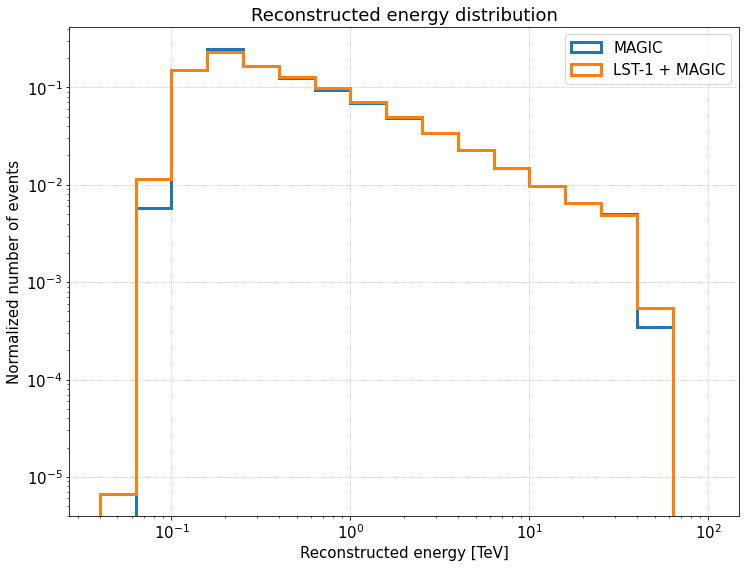

In [12]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-2, 2, 21)[3:]   # unit: [TeV]

# ============
# === Main ===
# ============

print('Energy bins:')
print(energy_bins*u.TeV)

plt.figure()
plt.title('Reconstructed energy distribution')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Normalized number of events')
plt.loglog()
plt.grid()

plt.hist(
    dl2_magic['reco_energy'].to_numpy(), bins=energy_bins,
    weights=np.repeat(1/len(dl2_magic), len(dl2_magic)),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['reco_energy'].to_numpy(), bins=energy_bins,
    weights=np.repeat(1/len(dl2_mlst), len(dl2_mlst)),
    label='LST-1 + MAGIC', histtype='step', linewidth=3,
)

plt.legend()

# Check the gammaness

### Check the gammaness distributions:

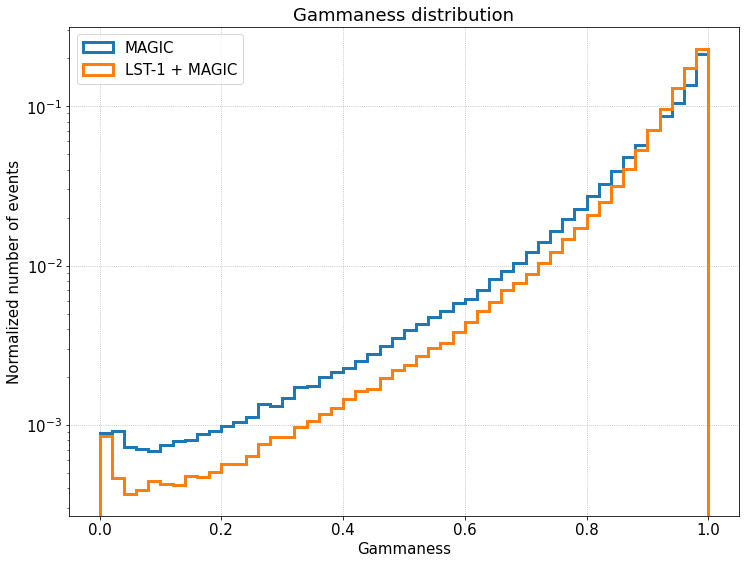

In [13]:
plt.figure()
plt.title('Gammaness distribution')
plt.xlabel('Gammaness')
plt.ylabel('Normalized number of events')
plt.semilogy()
plt.grid()

gam_bins  = np.linspace(0, 1, 51)

plt.hist(
    dl2_magic['gammaness'].to_numpy(), bins=gam_bins, 
    weights=np.repeat(1/len(dl2_magic), len(dl2_magic)),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['gammaness'].to_numpy(), bins=gam_bins, 
    weights=np.repeat(1/len(dl2_mlst), len(dl2_mlst)),
    label='LST-1 + MAGIC', histtype='step', linewidth=3,
)

plt.legend(loc='upper left')

### Check the gammaness distributions with different energy bins:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


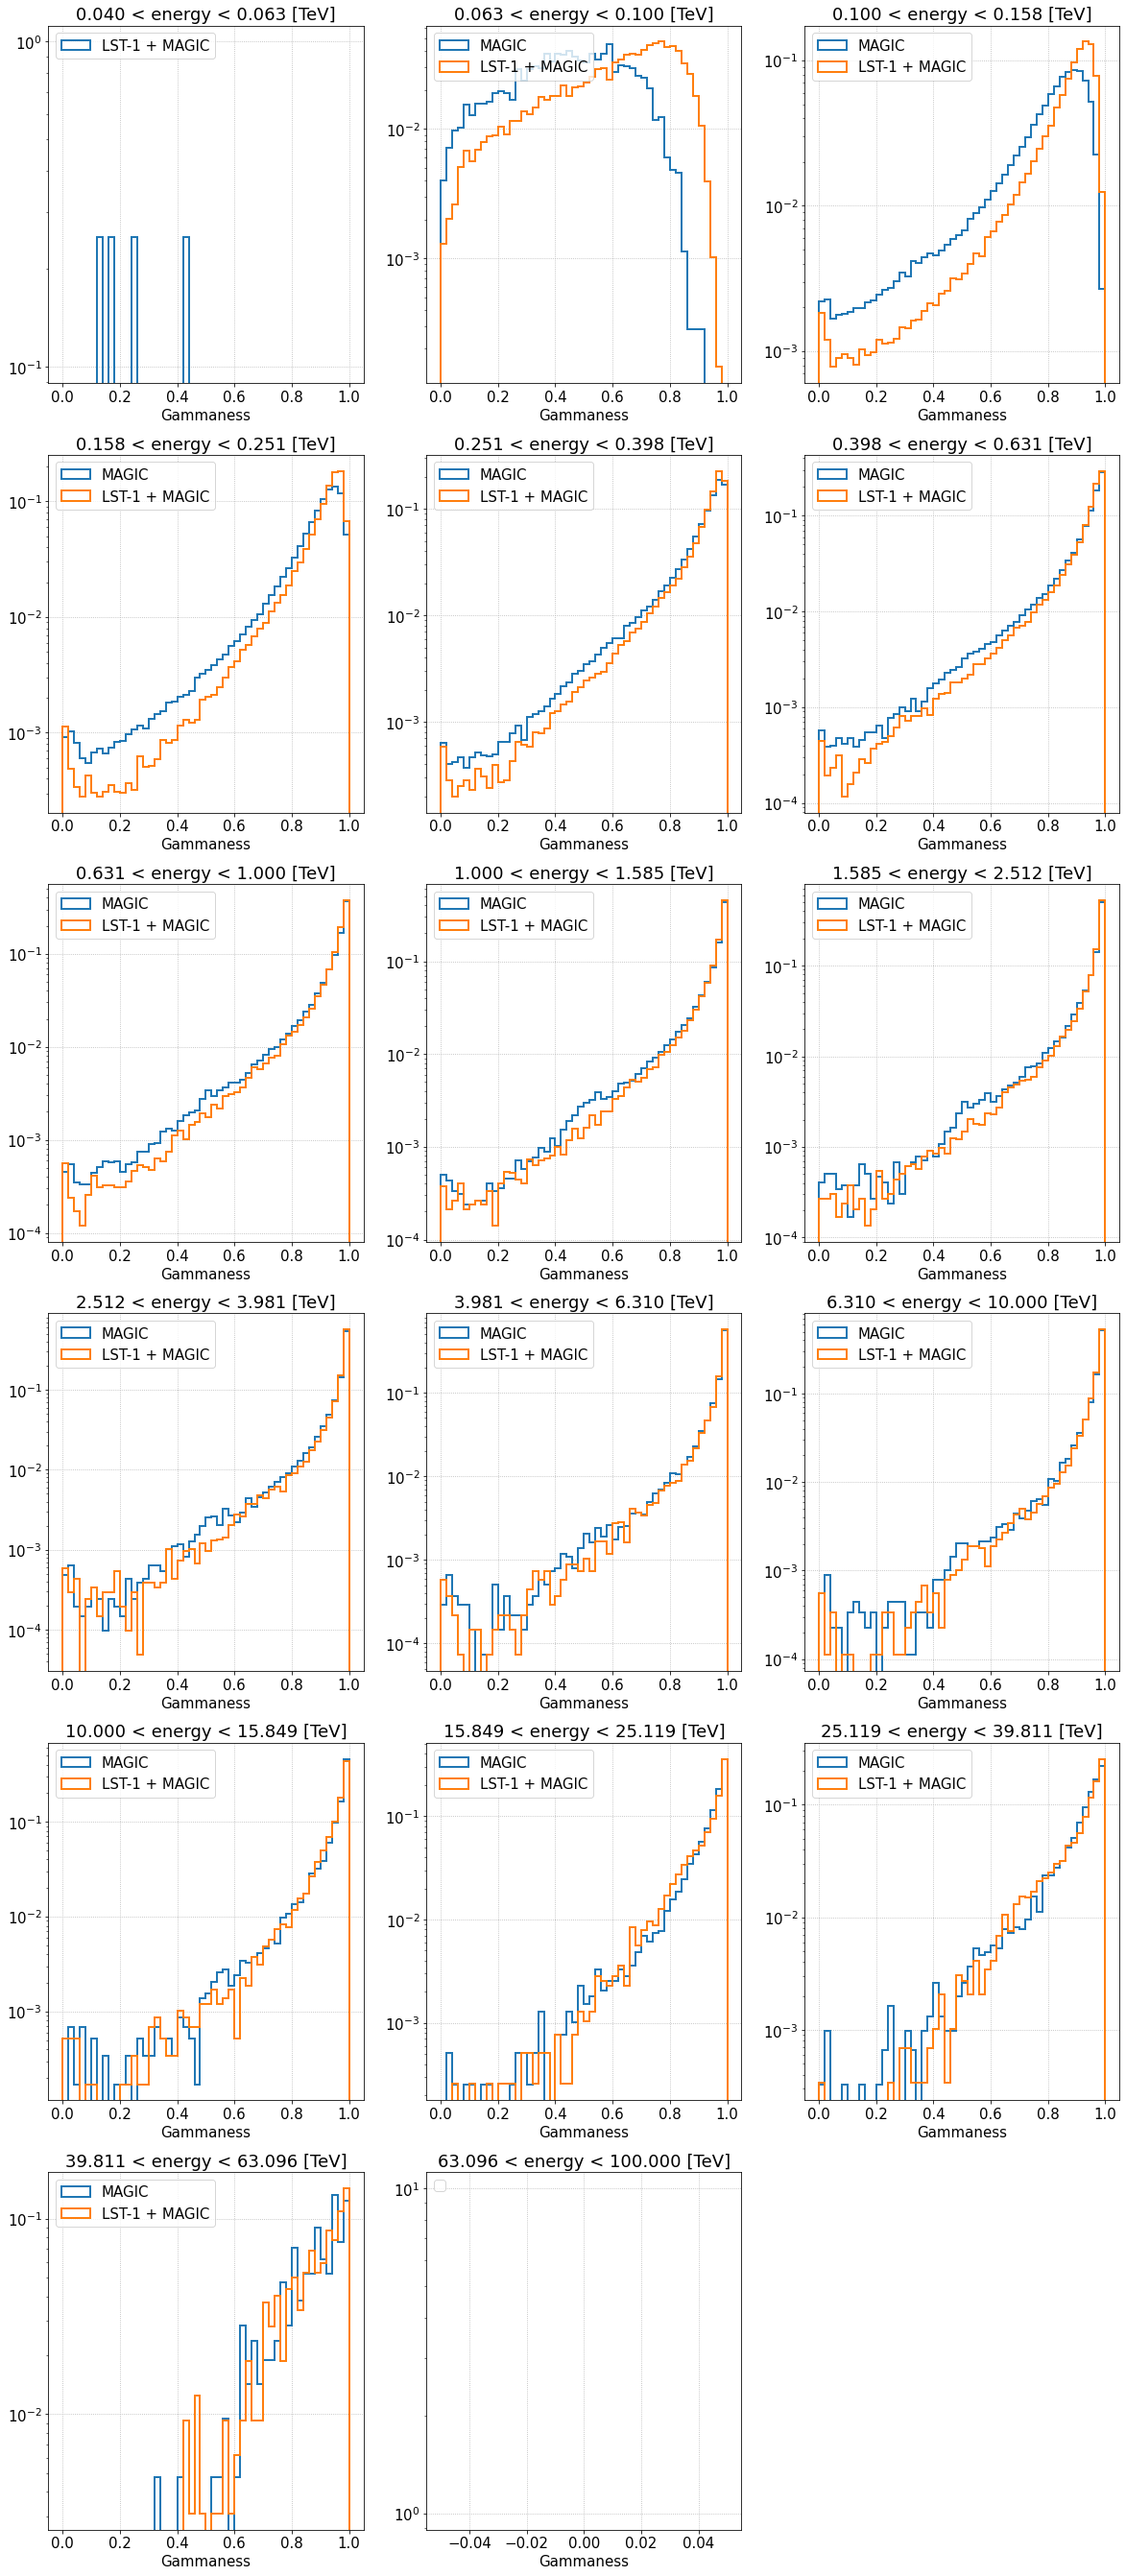

In [14]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1])/n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows*8))

for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    energy_mask = f'(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})'
    
    df_magic = dl2_magic.query(energy_mask)
    df_mlst = dl2_mlst.query(energy_mask)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f'{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]')
    plt.xlabel('Gammaness')
    plt.semilogy()
    plt.grid()

    if len(df_magic) > 0:
        plt.hist(
            df_magic['gammaness'].to_numpy(), bins=gam_bins,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )
        
    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['gammaness'].to_numpy(), bins=gam_bins,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC', histtype='step', linewidth=2,
        )

    plt.legend(loc='upper left')


# Check gammaness cuts satisfying a gamma efficiency

### Compute gammaness cuts:

In [15]:
# ================
# === Settings ===
# ================

gh_efficiency = 0.9

# ============
# === Main ===
# ============

print(f'Gamma/hadron efficiency: {gh_efficiency}')

percentile = 100 * (1 - gh_efficiency)

gh_cuts_magic = calculate_percentile_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=percentile,
)

gh_cuts_mlst = calculate_percentile_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=percentile,
)

print('\nMAGIC gammaness cuts:\n')
print(gh_cuts_magic)

print('\nLST-1 + MAGIC gammaness cuts:\n')
print(gh_cuts_mlst)

Gamma/hadron efficiency: 0.9

MAGIC gammaness cuts:

        low                  high               center               cut        
        TeV                  TeV                 TeV                            
-------------------- ------------------- ------------------- -------------------
0.039810717055349734 0.06309573444801933 0.05145322575168453                 0.0
 0.06309573444801933                 0.1 0.08154786722400967 0.17212777777777777
                 0.1 0.15848931924611143  0.1292446596230557  0.5468333333333333
 0.15848931924611143 0.25118864315095807 0.20483898119853475   0.705347619047619
 0.25118864315095807  0.3981071705534973 0.32464790685222766  0.7228916666666667
  0.3981071705534973  0.6309573444801934  0.5145322575168454  0.7478809523809524
  0.6309573444801934                 1.0  0.8154786722400966  0.7659166666666666
                 1.0   1.584893192461114   1.292446596230557  0.7874166666666665
   1.584893192461114  2.5118864315095824   2.04838981198

### Plot the gammaness cuts:

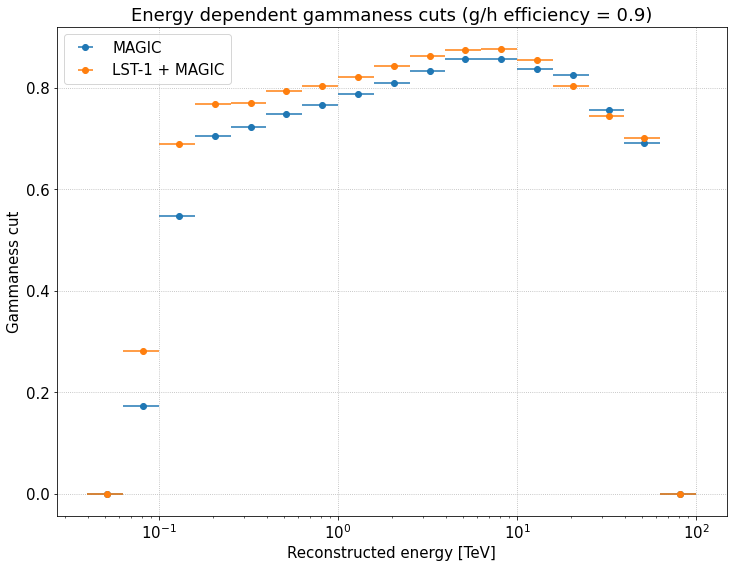

In [16]:
plt.figure()
plt.title(f'Energy dependent gammaness cuts (g/h efficiency = {gh_efficiency})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Gammaness cut')
plt.semilogx()
plt.grid()

plt.errorbar(
    x=gh_cuts_magic['center'].value, y=gh_cuts_magic['cut'].value,
    xerr=[gh_cuts_magic['center'].value - gh_cuts_magic['low'].value,
          gh_cuts_magic['high'].value - gh_cuts_magic['center'].value],
    label='MAGIC', fmt='o',
)

plt.errorbar(
    x=gh_cuts_mlst['center'].value, y=gh_cuts_mlst['cut'].value,
    xerr=[gh_cuts_mlst['center'].value - gh_cuts_mlst['low'].value,
          gh_cuts_mlst['high'].value - gh_cuts_mlst['center'].value],
    label='LST-1 + MAGIC', fmt='o',
)

plt.legend()

### Apply the gammaness cuts:

In [17]:
mask_gh_magic = evaluate_binned_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    cut_table=gh_cuts_magic,
    op=operator.ge,
)

mask_gh_mlst = evaluate_binned_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    cut_table=gh_cuts_mlst,
    op=operator.ge,
)

print('Applying the gammaness cuts...\n')

dl2_magic_gcut = dl2_magic[mask_gh_magic]
dl2_mlst_gcut = dl2_mlst[mask_gh_mlst]

print(f'MAGIC: {len(dl2_magic_gcut)} events')
print(f'LST-1 + MAGIC: {len(dl2_mlst_gcut)} events')

Applying the gammaness cuts...

MAGIC: 542446 events
LST-1 + MAGIC: 537930 events


# Check the reconstructed directions

### Check the theta2 distributions:

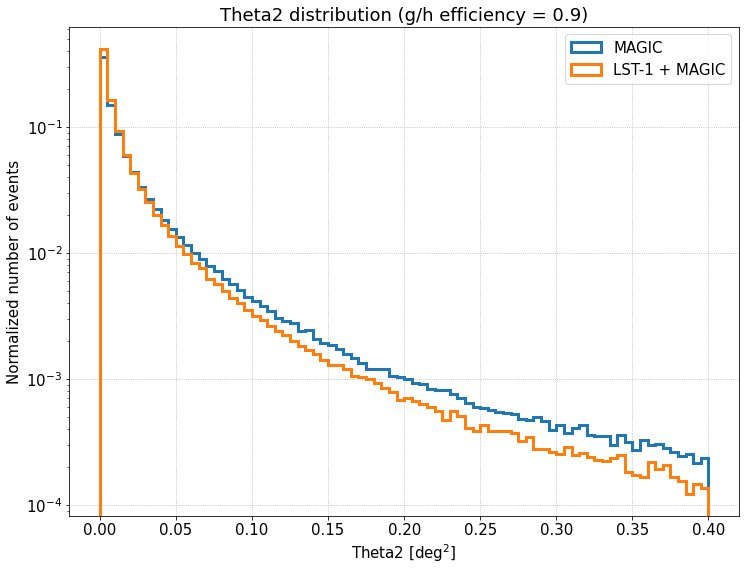

In [18]:
plt.figure()
plt.title(f'Theta2 distribution (g/h efficiency = {gh_efficiency})')
plt.xlabel('Theta2 [deg$^2$]')
plt.ylabel('Normalized number of events')
plt.semilogy()
plt.grid()

theta2_bins = np.linspace(0, 0.4, 81)

plt.hist(
    dl2_magic_gcut['theta2'].to_numpy(), bins=theta2_bins, 
    weights=np.repeat(1/len(dl2_magic_gcut), len(dl2_magic_gcut)),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst_gcut['theta2'].to_numpy(), bins=theta2_bins,
    weights=np.repeat(1/len(dl2_mlst_gcut), len(dl2_mlst_gcut)),
    label='LST-1 + MAGIC', histtype='step', linewidth=3,
)

plt.legend()

### Check the theta2 distributions with different energy bins:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


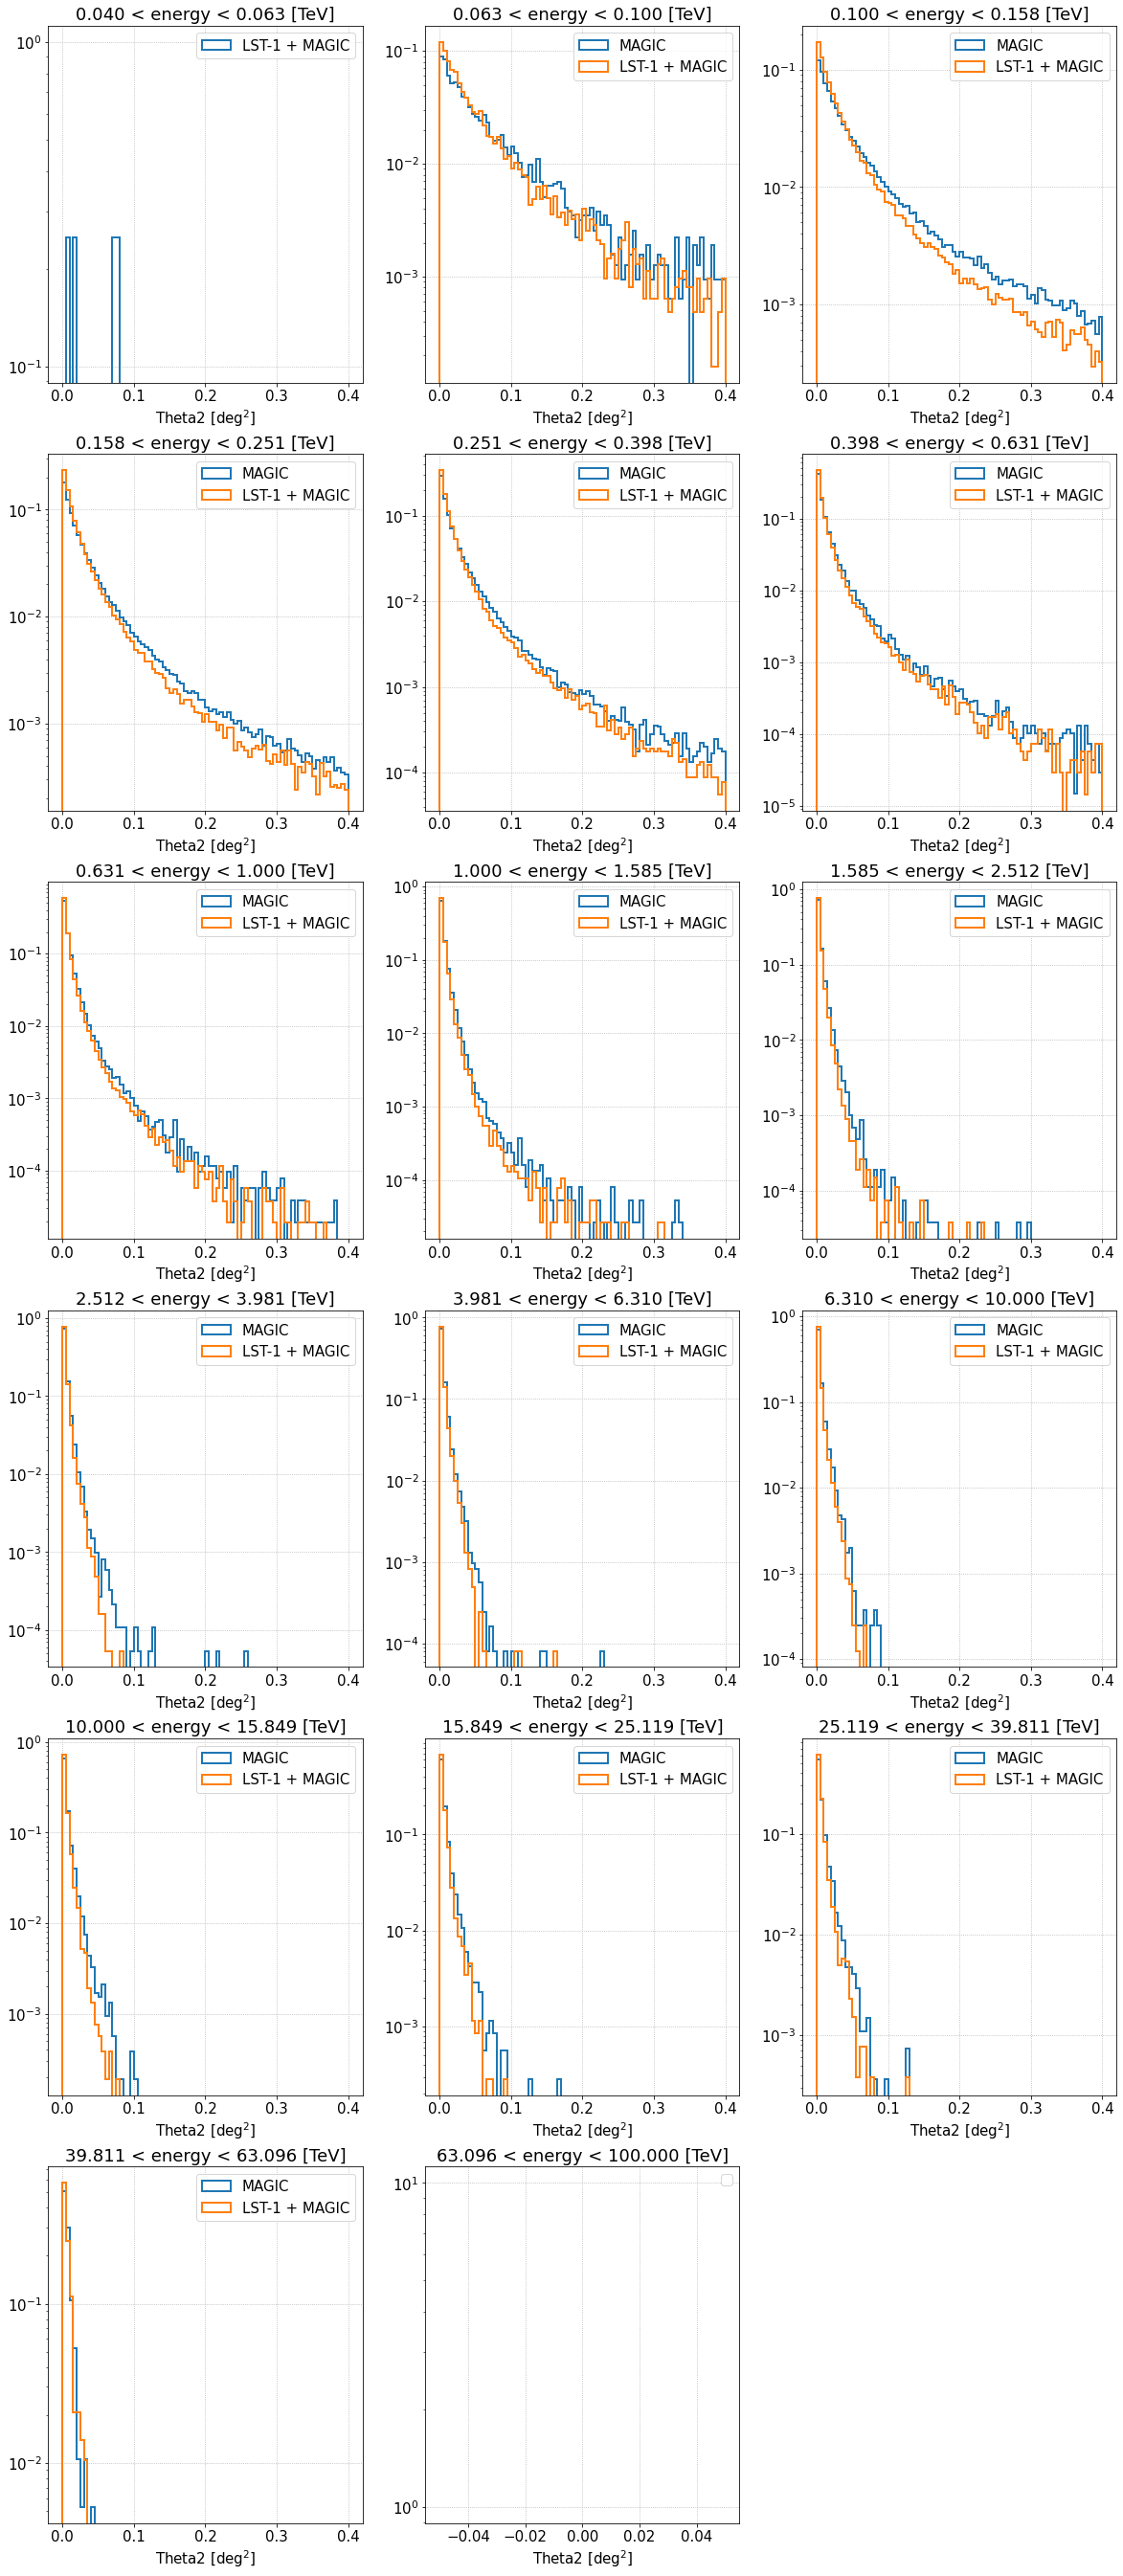

In [19]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1])/n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows*8))

for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    energy_mask = f'(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})'
    
    df_magic = dl2_magic_gcut.query(energy_mask)
    df_mlst = dl2_mlst_gcut.query(energy_mask)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f'{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]')
    plt.xlabel('Theta2 [deg$^2$]')
    plt.semilogy()
    plt.grid()

    if len(df_magic) > 0:        
        plt.hist(
            df_magic['theta2'].to_numpy(), bins=theta2_bins,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )
        
    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['theta2'].to_numpy(), bins=theta2_bins,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC', histtype='step', linewidth=2,
        )

    plt.legend(loc='upper right')


# Check the angular resolution

### Compute the angular resolutions:

In [20]:
angres_magic = []
angres_mlst = []

for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    energy_mask = f'(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})'
    
    df_magic = dl2_magic_gcut.query(energy_mask)
    df_mlst = dl2_mlst_gcut.query(energy_mask)
    
    res_magic = angular_resolution(
        reco_alt=df_magic['reco_alt'].to_numpy(),
        reco_az=df_magic['reco_az'].to_numpy(),
        true_alt=df_magic['true_alt'].to_numpy(),
        true_az=df_magic['true_az'].to_numpy(),
    )
    
    res_mlst = angular_resolution(
        reco_alt=df_mlst['reco_alt'].to_numpy(),
        reco_az=df_mlst['reco_az'].to_numpy(),
        true_alt=df_mlst['true_alt'].to_numpy(),
        true_az=df_mlst['true_az'].to_numpy(),
    )
    
    angres_magic.append(res_magic)
    angres_mlst.append(res_mlst)
    
angres_magic = np.array(angres_magic)
angres_mlst = np.array(angres_mlst)

print('MAGIC angular resolution:')
print(angres_magic[:, 0]*u.deg)

print('\nLST-1 + MAGIC angular resolution:')
print(angres_mlst[:, 0]*u.deg)

MAGIC angular resolution:
[0.         0.36618179 0.32687282 0.26567563 0.19833138 0.14389371
 0.113681   0.09211422 0.08145663 0.07863304 0.07941763 0.08136886
 0.08958042 0.09677902 0.1068148  0.10284465 0.        ] deg

LST-1 + MAGIC angular resolution:
[0.35482355 0.2981213  0.25145824 0.21082895 0.1653067  0.12729171
 0.1026635  0.08488235 0.0753601  0.07187997 0.07229884 0.07449732
 0.0788914  0.08641531 0.09287707 0.09690239 0.        ] deg


### Plot the anguler resolutions:

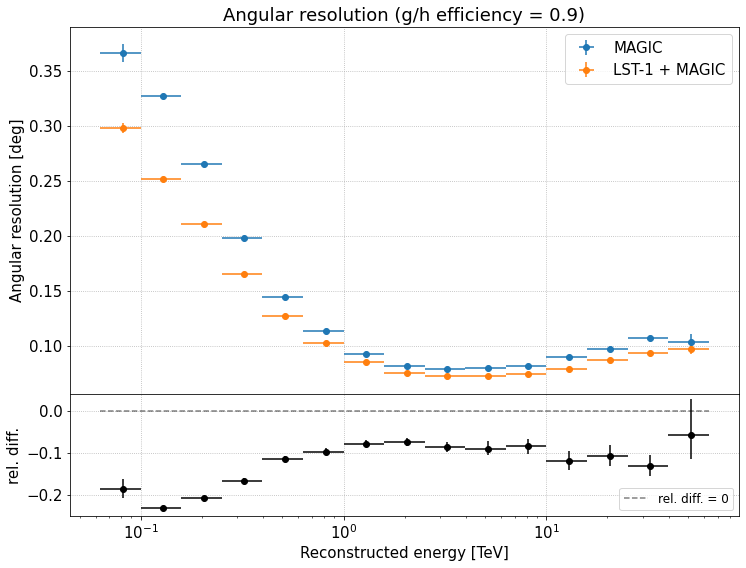

In [21]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

mask_zeros = np.logical_and(
    angres_magic[:, 0] > 0,
    angres_mlst[:, 0] > 0,
)

angres_magic_masked = angres_magic[mask_zeros]
angres_mlst_masked = angres_mlst[mask_zeros]

ebins_lo = energy_bins[:-1][mask_zeros]
ebins_hi = energy_bins[1:][mask_zeros]
ebins_center = (ebins_lo + ebins_hi) / 2

# Plot the resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Angular resolution (g/h efficiency = {gh_efficiency})')
ax1.set_ylabel('Angular resolution [deg]')
ax1.semilogx()
ax1.grid()

ax1.errorbar(
    x=ebins_center, y=angres_magic_masked[:, 0],
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=[angres_magic_masked[:, 0] - angres_magic_masked[:, 1],
          angres_magic_masked[:, 2] - angres_magic_masked[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_center, y=angres_mlst_masked[:, 0],
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=[angres_mlst_masked[:, 0] - angres_mlst_masked[:, 1],
          angres_mlst_masked[:, 2] - angres_mlst_masked[:, 0]],
    label='LST-1 + MAGIC', fmt='o', 
)

ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative differences:
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()
ax2.grid()

rel_diff, rel_diff_err = calculate_relative_difference(angres_magic_masked, angres_mlst_masked)

ax2.errorbar(
    x=ebins_center, y=rel_diff,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=rel_diff_err, fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.legend(fontsize=12)
plt.subplots_adjust(hspace=.0)

# Check theta2 cuts satisfying a gamma efficiency

### Compute theta2 cuts:

In [22]:
# ================
# === Settings ===
# ================

theta2_efficiency = 0.75

# ============
# === Main ===
# ============

print(f'Theta2 efficiency: {theta2_efficiency}')

percentile = 100 * theta2_efficiency

theta2_cuts_magic = calculate_percentile_cut(
    values=dl2_magic_gcut['theta2'].to_numpy(),
    bin_values=u.Quantity(dl2_magic_gcut['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=dl2_magic_gcut['theta2'].max(),
    percentile=percentile,
)

theta2_cuts_mlst = calculate_percentile_cut(
    values=dl2_mlst_gcut['theta2'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst_gcut['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=dl2_mlst_gcut['theta2'].max(),
    percentile=percentile,
)

print('\nMAGIC theta2 cuts:\n')
print(theta2_cuts_magic)

print('\n\nLST-1 + MAGIC theta2 cuts:\n')
print(theta2_cuts_mlst)

Theta2 efficiency: 0.75

MAGIC theta2 cuts:

        low                  high               center               cut         
        TeV                  TeV                 TeV                             
-------------------- ------------------- ------------------- --------------------
0.039810717055349734 0.06309573444801933 0.05145322575168453    13.85143768162886
 0.06309573444801933                 0.1 0.08154786722400967  0.11270192251593744
                 0.1 0.15848931924611143  0.1292446596230557  0.09947103578394494
 0.15848931924611143 0.25118864315095807 0.20483898119853475   0.0655918760636584
 0.25118864315095807  0.3981071705534973 0.32464790685222766 0.035105833306813536
  0.3981071705534973  0.6309573444801934  0.5145322575168454 0.018039223334690678
  0.6309573444801934                 1.0  0.8154786722400966 0.011095625895376954
                 1.0   1.584893192461114   1.292446596230557 0.007259698065994686
   1.584893192461114  2.5118864315095824   2.04838981

### Plot the theta2 cuts:

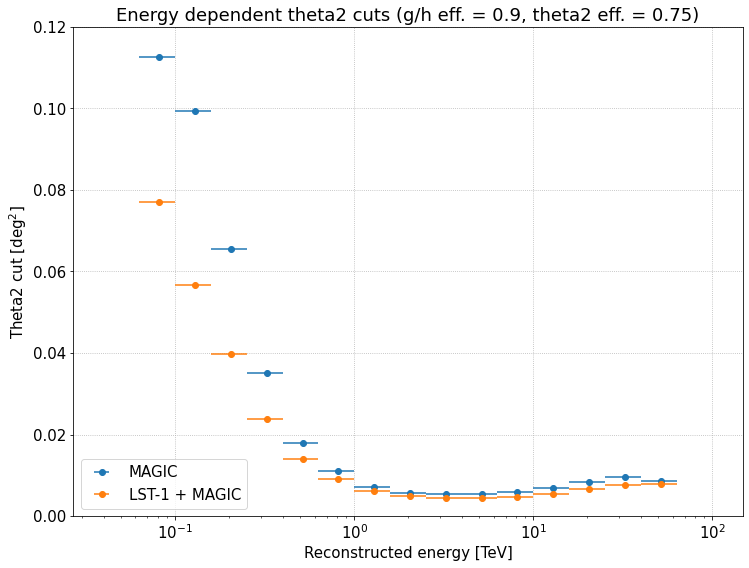

In [23]:
plt.figure()
plt.title(f'Energy dependent theta2 cuts (g/h eff. = {gh_efficiency}, theta2 eff. = {theta2_efficiency})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Theta2 cut [deg$^2$]')
plt.ylim(0, 0.12)
plt.semilogx()
plt.grid()

plt.errorbar(
    x=theta2_cuts_magic['center'].value, y=theta2_cuts_magic['cut'].value,
    xerr=[theta2_cuts_magic['center'].value - theta2_cuts_magic['low'].value,
          theta2_cuts_magic['high'].value - theta2_cuts_magic['center'].value],
    label='MAGIC', fmt='o',
)

plt.errorbar(
    x=theta2_cuts_mlst['center'].value, y=theta2_cuts_mlst['cut'].value,
    xerr=[theta2_cuts_mlst['center'].value - theta2_cuts_mlst['low'].value,
          theta2_cuts_mlst['high'].value - theta2_cuts_mlst['center'].value],
    label='LST-1 + MAGIC', fmt='o',
)

plt.legend()

### Apply the theta2 cuts:

In [24]:
mask_theta2_magic = evaluate_binned_cut(
    values=dl2_magic_gcut['theta2'].to_numpy(),
    bin_values=u.Quantity(dl2_magic_gcut['reco_energy'].to_numpy(), u.TeV),
    cut_table=theta2_cuts_magic,
    op=operator.le,
)

mask_theta2_mlst = evaluate_binned_cut(
    values=dl2_mlst_gcut['theta2'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst_gcut['reco_energy'].to_numpy(), u.TeV),
    cut_table=theta2_cuts_mlst,
    op=operator.le,
)

print('Applying the gammaness cuts...\n')

dl2_magic_gtcuts = dl2_magic_gcut[mask_theta2_magic]
dl2_mlst_gtcuts = dl2_mlst_gcut[mask_theta2_mlst]

print(f'MAGIC: {len(dl2_magic_gtcuts)} events')
print(f'LST-1 + MAGIC: {len(dl2_mlst_gtcuts)} events')

Applying the gammaness cuts...

MAGIC: 406833 events
LST-1 + MAGIC: 403446 events


# Check the effective area

### Get the simulation information:

In [25]:
sim_config = pd.read_hdf(input_file, key='simulation/config')

n_runs = len(np.unique(dl2_mlst_gtcuts.index.get_level_values('obs_id')))
n_total_showers = n_runs * sim_config['num_showers'].iloc[0] * sim_config['shower_reuse'].iloc[0]

sim_info = SimulatedEventsInfo(
    n_showers=n_total_showers,
    energy_min=u.Quantity(sim_config['energy_range_min'].iloc[0], u.TeV),
    energy_max=u.Quantity(sim_config['energy_range_max'].iloc[0], u.TeV),
    max_impact=u.Quantity(sim_config['max_scatter_range'].iloc[0], u.m),
    spectral_index=sim_config['spectral_index'].iloc[0],
    viewcone=u.Quantity(sim_config['max_viewcone_radius'].iloc[0], u.deg),
)

print(sim_info)

SimulatedEventsInfo(n_showers=120000000, energy_min=0.005 TeV, energy_max=50.00 TeV, spectral_index=-2.0, max_impact=600.00 m, viewcone=0.0 deg)


### Compute the effective area:

In [26]:
qtable_magic = QTable.from_pandas(dl2_magic_gtcuts)
qtable_magic['true_energy'] *= u.TeV

qtable_mlst = QTable.from_pandas(dl2_mlst_gtcuts)
qtable_mlst['true_energy'] *= u.TeV

aeff_magic = effective_area_per_energy(
    selected_events=qtable_magic,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

aeff_mlst = effective_area_per_energy(
    selected_events=qtable_mlst,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print('MAGIC effective area:')
print(aeff_magic)

print('\nLST-1 + MAGIC effective area:')
print(aeff_mlst)

MAGIC effective area:
[   370.85656251   5278.31168669  28946.9835148   64771.67212919
  89478.58754319 108558.90593262 130011.455013   149170.50309642
 165488.66381091 180973.83969258 194923.34785009 195052.62905708
 204797.90379918 212476.27415194 227836.91734177 201037.33844047
             nan] m2

LST-1 + MAGIC effective area:
[   327.75261994   5132.33640012  28599.69529888  63353.54476799
  88036.64669245 109242.06275829 131548.5457789  150564.76313974
 165148.70177227 180409.37886133 193825.4172374  193828.11230437
 204848.97559564 211181.1806714  228093.49044688 190359.53108741
             nan] m2


### Plot the effective area:

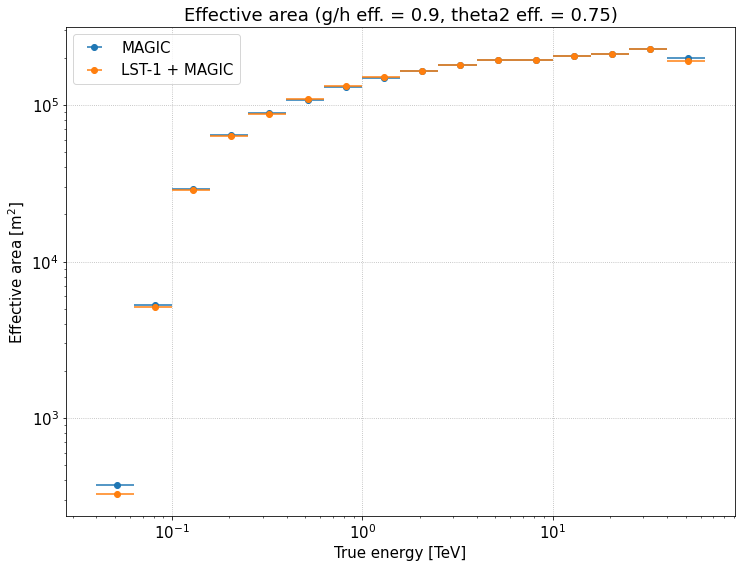

In [27]:
plt.figure()
plt.title(f'Effective area (g/h eff. = {gh_efficiency}, theta2 eff. = {theta2_efficiency})')
plt.xlabel('True energy [TeV]')
plt.ylabel('Effective area [m$^2$]')
plt.loglog()
plt.grid()

mask_nan = np.logical_and(~np.isnan(aeff_magic), ~np.isnan(aeff_mlst))

aeff_magic_masked = aeff_magic[mask_nan]
aeff_mlst_masked = aeff_mlst[mask_nan]

ebins_lo = energy_bins[:-1][mask_nan]
ebins_hi = energy_bins[1:][mask_nan]
ebins_center = (ebins_lo + ebins_hi) / 2

plt.errorbar(
    x=ebins_center, y=aeff_magic_masked.value,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    x=ebins_center, y=aeff_mlst_masked.value,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    fmt='o', label='LST-1 + MAGIC',
)

plt.legend()

# Check the energy resolution

### Compute the energy resolutions:

In [28]:
engres_magic = []
engres_mlst = []

for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    energy_mask = f'(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})'
    
    df_magic = dl2_magic_gtcuts.query(energy_mask)
    df_mlst = dl2_mlst_gtcuts.query(energy_mask)
    
    res_magic = energy_resolution(
        true_energy=df_magic['true_energy'].to_numpy(),
        reco_energy=df_magic['reco_energy'].to_numpy(),
    )
    
    res_mlst = energy_resolution(
        true_energy=df_mlst['true_energy'].to_numpy(),
        reco_energy=df_mlst['reco_energy'].to_numpy(),
    )
    
    engres_magic.append(res_magic)
    engres_mlst.append(res_mlst)
    
engres_magic = np.array(engres_magic)
engres_mlst = np.array(engres_mlst)

print('MAGIC energy resolution:')
print(engres_magic[:, 0])

print('\nLST-1 + MAGIC energy resolution:')
print(engres_mlst[:, 0])

MAGIC energy resolution:
[0.         0.39378999 0.3105937  0.24843788 0.19651948 0.16535493
 0.14234646 0.125357   0.11045265 0.10836575 0.10001175 0.10098823
 0.10661977 0.12112444 0.13902019 0.12641434 0.        ]

LST-1 + MAGIC energy resolution:
[0.32200641 0.33689237 0.25631937 0.18702585 0.15206422 0.13070876
 0.11458302 0.10276832 0.09219341 0.08765571 0.08506875 0.08521961
 0.08984774 0.10329354 0.11468073 0.11619013 0.        ]


### Plot the energy resolutions:

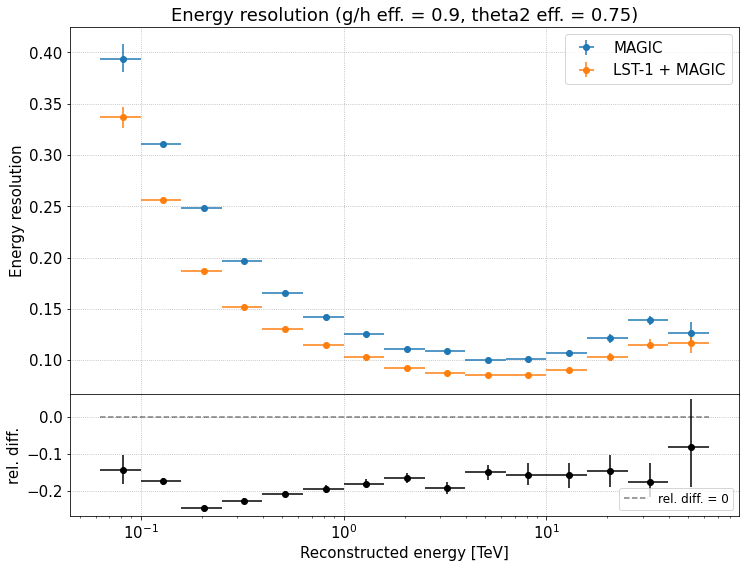

In [29]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

mask_zeros = np.logical_and(
    engres_magic[:, 0] > 0,
    engres_mlst[:, 0] > 0,
)

engres_magic_masked = engres_magic[mask_zeros]
engres_mlst_masked = engres_mlst[mask_zeros]

ebins_lo = energy_bins[:-1][mask_zeros]
ebins_hi = energy_bins[1:][mask_zeros]
ebins_center = (ebins_lo + ebins_hi) / 2

# Plot the resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Energy resolution (g/h eff. = {gh_efficiency}, theta2 eff. = {theta2_efficiency})')
ax1.set_ylabel('Energy resolution')
ax1.semilogx()
ax1.grid()

ax1.errorbar(
    x=ebins_center, y=engres_magic_masked[:, 0],
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=[engres_magic_masked[:, 0] - engres_magic_masked[:, 1],
          engres_magic_masked[:, 2] - engres_magic_masked[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_center, y=engres_mlst_masked[:, 0],
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=[engres_mlst_masked[:, 0] - engres_mlst_masked[:, 1],
          engres_mlst_masked[:, 2] - engres_mlst_masked[:, 0]],
    label='LST-1 + MAGIC', fmt='o', 
)

ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative differences:
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()
ax2.grid()

rel_diff, rel_diff_err = calculate_relative_difference(engres_magic_masked, engres_mlst_masked)

ax2.errorbar(
    x=ebins_center, y=rel_diff,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    yerr=rel_diff_err, fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.legend(fontsize=12)
plt.subplots_adjust(hspace=.0)

# Check the energy bias

### Compute the energy biases:

In [30]:
engbias_magic = []
engbias_mlst = []

for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    energy_mask = f'(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})'
    
    df_magic = dl2_magic_gtcuts.query(energy_mask)
    df_mlst = dl2_mlst_gtcuts.query(energy_mask)
    
    bias_magic = relative_bias(
        true=df_magic['true_energy'].to_numpy(),
        reco=df_magic['reco_energy'].to_numpy(),
    )
    
    bias_mlst = relative_bias(
        true=df_mlst['true_energy'].to_numpy(),
        reco=df_mlst['reco_energy'].to_numpy(),
    )
    
    engbias_magic.append(bias_magic)
    engbias_mlst.append(bias_mlst)
    
engbias_magic = np.array(engbias_magic)
engbias_mlst = np.array(engbias_mlst)

print('MAGIC energy bias:')
print(engbias_magic)

print('\nLST-1 + MAGIC energy bias:')
print(engbias_mlst)

MAGIC energy bias:
[ 0.          0.16740321  0.09131007  0.01566247 -0.01484148 -0.01623488
 -0.01606985 -0.01274314 -0.01287712 -0.01431904 -0.00964732 -0.01201971
 -0.01148814 -0.01297533 -0.04641165 -0.08871553  0.        ]

LST-1 + MAGIC energy bias:
[-0.15811467  0.15729498  0.09692934  0.00886667 -0.01704738 -0.01619532
 -0.01530132 -0.00965388 -0.01093497 -0.01083347 -0.00839653 -0.00803201
 -0.0079532  -0.00872163 -0.03267759 -0.07511259  0.        ]


### Plot the energy biases:

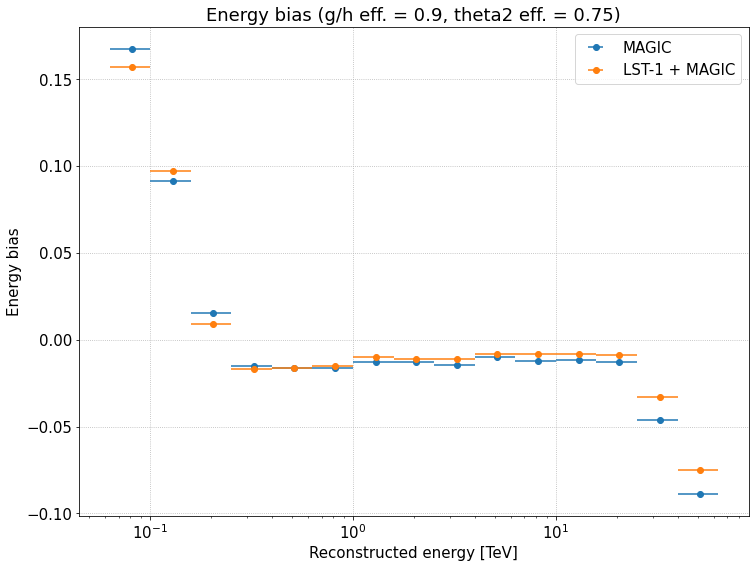

In [31]:
mask_zeros = np.logical_and(
    engbias_magic != 0,
    engbias_mlst != 0,
)

engbias_magic_masked = engbias_magic[mask_zeros]
engbias_mlst_masked = engbias_mlst[mask_zeros]

ebins_lo = energy_bins[:-1][mask_zeros]
ebins_hi = energy_bins[1:][mask_zeros]
ebins_center = (ebins_lo + ebins_hi) / 2

plt.figure()
plt.title(f'Energy bias (g/h eff. = {gh_efficiency}, theta2 eff. = {theta2_efficiency})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Energy bias')
plt.semilogx()
plt.grid()

plt.errorbar(
    ebins_center, engbias_magic_masked,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    ebins_center, engbias_mlst_masked,
    xerr=[ebins_center - ebins_lo, ebins_hi - ebins_center],
    fmt='o', label='LST-1 + MAGIC',
)

plt.legend()